In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from datetime import datetime

In [38]:
# Load data
prices_df = pd.read_csv('../data/day_ahead_energy_prices.csv', parse_dates=[0], index_col=0)
mix_df = pd.read_csv('../data/daily_market_mix.csv', header=None, names=['Date', 'Energy Source', 'Share'])

In [39]:
# Convert 'Date' to datetime format and pivot mix data
mix_df['Date'] = pd.to_datetime(mix_df['Date'], format='%Y_%m_%d')
mix_df = mix_df.pivot(index='Date', columns='Energy Source', values='Share').fillna(0).reset_index()

# Repeat each daily row 24 times and add hourly timestamps
hourly_mix_df = mix_df.loc[mix_df.index.repeat(24)].reset_index(drop=True)
hourly_mix_df['Hour'] = list(range(24)) * (len(hourly_mix_df) // 24)
hourly_mix_df['Datetime'] = hourly_mix_df['Date'] + pd.to_timedelta(hourly_mix_df['Hour'], unit='h')
hourly_mix_df['Datetime'] = hourly_mix_df['Datetime'].dt.tz_localize('UTC')
hourly_mix_df.set_index('Datetime', inplace=True)
hourly_mix_df.drop(['Date', 'Hour'], axis=1, inplace=True)

# Clean up prices_df and ensure timezone is set to UTC
prices_df.rename(columns={'hourly day-ahead energy price': 'Price'}, inplace=True)

# Ensure prices_df index is in UTC timezone
if prices_df.index.tz is None:
    prices_df.index = prices_df.index.tz_localize('UTC')
else:
    prices_df.index = prices_df.index.tz_convert('UTC')

# Define the date range for filtering
start_date = datetime(2024, 5, 1, tzinfo=pytz.UTC)
end_date = datetime(2024, 10, 29, tzinfo=pytz.UTC)

# Filter data based on the specified date range
filtered_prices_df = prices_df[(prices_df.index >= start_date) & (prices_df.index <= end_date)]
filtered_mix_df = hourly_mix_df[(hourly_mix_df.index >= start_date) & (hourly_mix_df.index <= end_date)]

# Merge filtered datasets
data = filtered_prices_df.merge(filtered_mix_df, left_index=True, right_index=True)

In [ ]:
# Separate features and labels
X = data.drop(columns=['Price'])
y = data['Price'].tolist()

# Split data for training and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the XGBoost model
best_params = {
    'base_score': float(0.20438597995798177),
    'colsample_bytree': float(0.932989723014941),
    'early_stopping_rounds': int(4),
    'gamma': float(0.0001751200398487085),
    'learning_rate': float(0.5),  # A high learning rate; consider adjusting based on model performance
    'max_depth': int(2),
    'min_child_weight': int(3),
    'n_estimators': int(5),
    'subsample': float(0.8159969087302229)
}

model = XGBRegressor(
    base_score=best_params['base_score'],
    colsample_bytree=best_params['colsample_bytree'],
    early_stopping_rounds=best_params['early_stopping_rounds'],
    gamma=best_params['gamma'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    objective='reg:squarederror',
)

model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=25)

# Prediction and evaluation
y_pred = model.predict(X_test)
mse = root_mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')

[0]	validation_0-rmse:57.90016	validation_1-rmse:54.56259
[4]	validation_0-rmse:41.43225	validation_1-rmse:39.79161
RMSE: 6.308059248822169


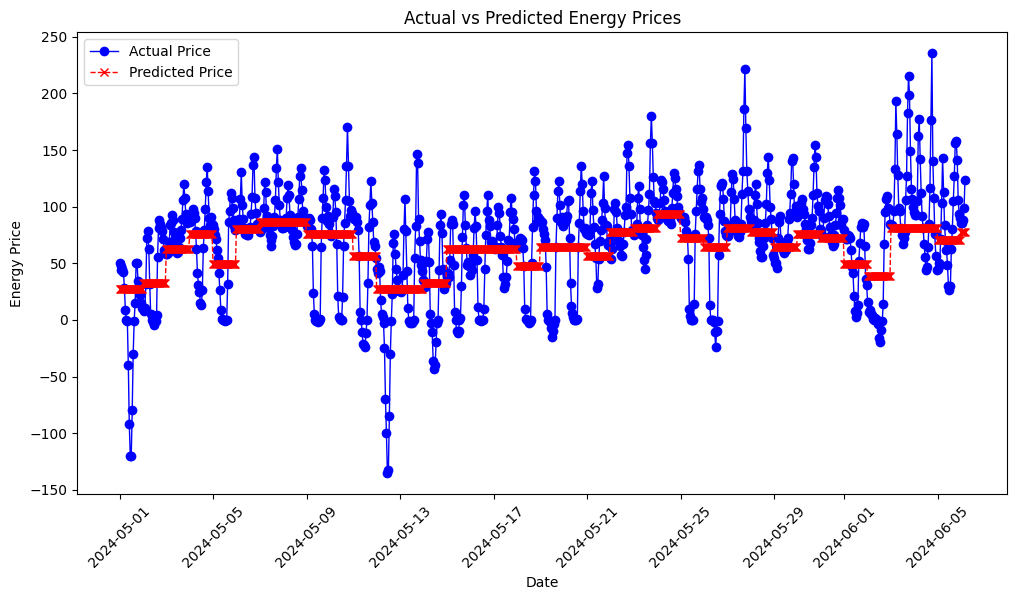

In [41]:
# Visualization of actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, label='Actual Price', color='blue', marker='o', linestyle='-', linewidth=1)
plt.plot(X_test.index, y_pred, label='Predicted Price', color='red', marker='x', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Energy Price')
plt.title('Actual vs Predicted Energy Prices')
plt.legend()
plt.xticks(rotation=45)
plt.show()

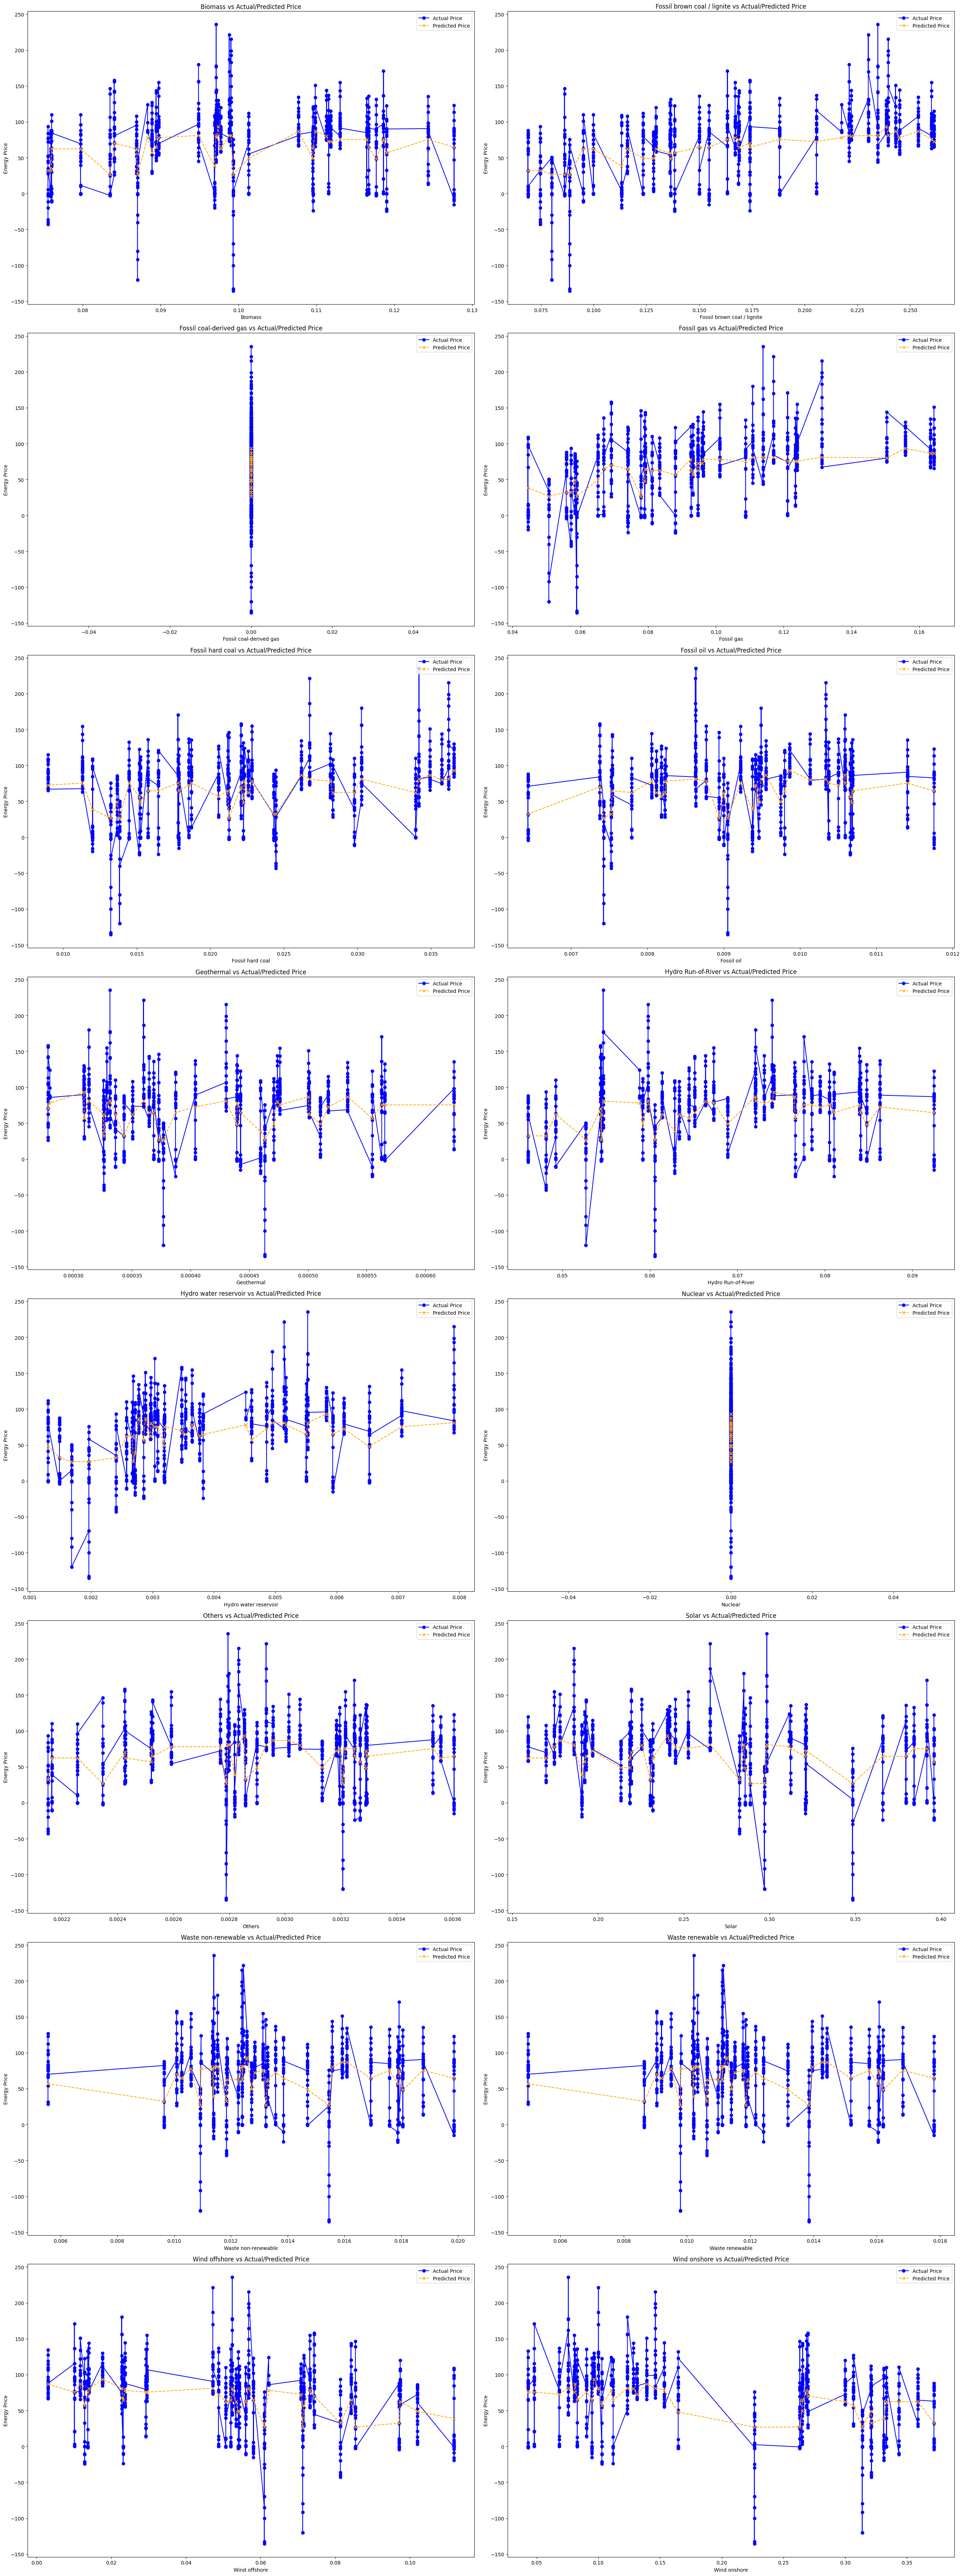

In [42]:
# Ensure y_test and y_pred are pandas Series with the correct index
y_test = pd.Series(y_test, index=X_test.index) if not isinstance(y_test, pd.Series) else y_test
y_pred = pd.Series(y_pred, index=X_test.index) if not isinstance(y_pred, pd.Series) else y_pred

# Visualization settings
num_features = len(X.columns)
fig, axes = plt.subplots(nrows=(num_features + 1) // 2, ncols=2, figsize=(27, num_features * 4.5))

# Plot for each feature
for i, feature in enumerate(X.columns):
    # Sort data for smoother line plots
    X_test_feature = X_test[feature].sort_values()
    y_test_sorted = y_test.loc[X_test_feature.index]
    y_pred_sorted = y_pred.loc[X_test_feature.index]
    
    # Plot actual and predicted prices
    ax = axes[i // 2, i % 2]
    ax.plot(X_test_feature, y_test_sorted, color='blue', marker='o', linestyle='-', label='Actual Price')
    ax.plot(X_test_feature, y_pred_sorted, color='orange', marker='x', linestyle='--', label='Predicted Price')
    
    # Set axis labels, title, and legend
    ax.set_title(f'{feature} vs Actual/Predicted Price')
    ax.set_xlabel(feature)
    ax.set_ylabel('Energy Price')
    ax.legend(loc='upper right')

# Hide any empty subplots
for j in range(i + 1, len(axes.flat)):
    fig.delaxes(axes.flat[j])

# Adjust plot layout
plt.tight_layout()
plt.show()
